Homework 7 \
Iba Baig \
DS4400

### Problem 1
#### part A)

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("evs_subset.csv")
y = np.where(df['drive'] == 'Front', -1, 1)
X = df[['topspeed', 'totaltorque']].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

#### part B)
In the plot below, the data points look separable by a linear boundary after preprocessing. Since there is a clear margin between Front and Rear drive vehicles, using a hard margin SVM might be appropriate. There will be a high classification accuracy because there are almost no overlaps or outliers that would prevent perfect separation by SVM.

In [4]:
import matplotlib.pyplot as plt

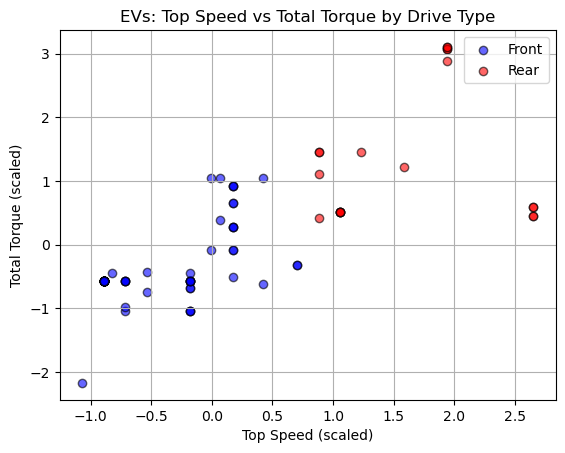

In [5]:
for drive_type, color, label in zip([-1, 1], ['blue', 'red'], ['Front', 'Rear']):
    idx = np.where(y == drive_type)
    plt.scatter(X_scaled[idx, 0], X_scaled[idx, 1], c=color, label=label, alpha=0.6, edgecolors='k')

plt.xlabel('Top Speed (scaled)')
plt.ylabel('Total Torque (scaled)')
plt.title('EVs: Top Speed vs Total Torque by Drive Type')
plt.legend()
plt.grid(True)
plt.show()

#### part C)

In [6]:
X_train_bias = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
X_test_bias = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

w = np.zeros((X_train_bias.shape[1], 1))
eta = 0.01

def dw(X, y, w):
    n = X.shape[0]
    return 2 * w - (1/n) * np.dot(X.T, y.reshape(-1, 1))

def GD(X, y, w):
    for i in range(1000):
        w = w - eta * dw(X, y, w)
    return w

w_final = GD(X_train_bias, y_train, w)
w = w_final / np.linalg.norm(w_final)
print(w)

[[-0.6308511 ]
 [ 0.57773955]
 [ 0.51792268]]


In [7]:
bool_neg1 = (y_train == -1)
neg1X = X_train_bias[bool_neg1, :]

store_projections_neg1 = np.zeros_like(neg1X)
for i in range(neg1X.shape[0]):
    xi = neg1X[i, :].reshape(-1, 1)
    store_projections_neg1[i] = (np.dot(w.T, xi) / np.dot(w.T, w) * w).flatten()

bool_pos1 = (y_train == 1)
pos1X = X_train_bias[bool_pos1, :]

store_projections_pos1 = np.zeros_like(pos1X)
for i in range(pos1X.shape[0]):
    xi = pos1X[i, :].reshape(-1, 1)
    store_projections_pos1[i] = (np.dot(w.T, xi) / np.dot(w.T, w) * w).flatten()

neg1_SV = 0
pos1_SV = 0
dij_min = np.linalg.norm(store_projections_neg1[neg1_SV] - store_projections_pos1[pos1_SV])

for i in range(neg1X.shape[0]):
    pi = store_projections_neg1[i]
    for j in range(pos1X.shape[0]):
        pj = store_projections_pos1[j]
        dij = np.linalg.norm(pi - pj)
        if dij < dij_min:
            dij_min = dij
            neg1_SV = i
            pos1_SV = j

print(neg1_SV)
print(pos1_SV)
print(dij_min)

b = - (np.linalg.norm(store_projections_neg1[neg1_SV]) + np.linalg.norm(store_projections_pos1[pos1_SV]))/2
print(f"b: {b:.4f}")

49
0
0.055031361041412
b: -0.1245


In [8]:
SVneg1 = neg1X[neg1_SV]
SVpos1 = pos1X[pos1_SV]
print(SVneg1)
print(SVpos1)

[1.         0.41909153 1.04410879]
[1.         0.87943069 0.42434928]


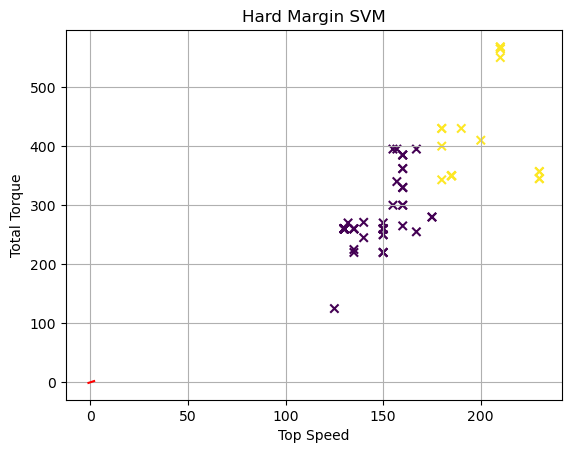

In [9]:
line_x = np.arange(-1, 2, 0.1)
line_y = -(w[0,0]/w[1,0])*line_x - (b/w[1,0])
plt.scatter(X[:,0], X[:,1], c=y, marker = 'x')

plt.plot(line_x, line_y, color='red')
plt.xlabel('Top Speed')
plt.ylabel('Total Torque')
plt.title('Hard Margin SVM')
plt.grid(True)
plt.show()

In [10]:
from sklearn.metrics import mean_squared_error, r2_score

preds = np.sign(np.dot(X_test_bias, w))

mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)

print(f"MSE: {mse:.4f}")
print(f"R squared: {r2:.4f}")

accuracy = np.mean(preds == y_test)
print(f"Classification accuracy from the test set: {accuracy:.4f}")

MSE: 0.0000
R squared: 1.0000
Classification accuracy from the test set: 0.5408


### Problem 2
#### part A)

In [11]:
from scipy.integrate import quad
from scipy.stats import norm
import autograd.numpy as np
from autograd.numpy import sqrt
from autograd import grad

In [12]:
n_total = 1589
n_positive = 1183
n_negative = n_total - n_positive

p_positive = n_positive / n_total
p_negative = n_negative / n_total

def H(probs):
    entropy = 0
    for p in probs:
        entropy -= np.log2(p) * p
    return entropy

H_Y = H([p_positive, p_negative])
print(f"H(Y): {H_Y:.4f}")

H(Y): 0.8199


#### part B)

In [13]:
respected = np.array([
    [188, 218],
    [246, 937]
])

hilarious = np.array([
    [215, 191],
    [442, 741]
])

p_respected = respected / n_total
p_hilarious = hilarious / n_total

def Hygx(prob_table):
    conditional_entropy = 0
    for row in range(prob_table.shape[0]):
        p_row = sum(prob_table[row, :])
        for p in prob_table[row, :]:
            if p_row > 0:
                p_cond = p / p_row
                if p_cond == 0.0:
                    conditional_entropy -= 0
                else:
                    conditional_entropy -= p_row * p_cond * np.log2(p_cond)
    return conditional_entropy

H_Y_given_X1 = Hygx(p_respected)
H_Y_given_X2 = Hygx(p_hilarious)

print(f"H(Y|X1 - Respected): {H_Y_given_X1:.4f}")
print(f"H(Y|X2 - Hilarious): {H_Y_given_X2:.4f}")

if H_Y_given_X1 < H_Y_given_X2:
    print("Respected (X1) provides more information about if the student would take the class again (Y).")
else:
    print("Hilarious (X2) provides more information about if the student would take the class again (Y).")

H(Y|X1 - Respected): 0.8036
H(Y|X2 - Hilarious): 0.9647
Respected (X1) provides more information about if the student would take the class again (Y).


#### part C)

In [2]:
df = pd.read_csv("rmp_df.csv")

onehot_rmp = pd.get_dummies(df, drop_first=True, dtype=int)

y = onehot_rmp.iloc[:, 0]
X = onehot_rmp.iloc[:, 1:]

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

NameError: name 'pd' is not defined

In [29]:
from sklearn import tree
from sklearn.metrics import classification_report, accuracy_score


Validation results max_depth=2:
              precision    recall  f1-score   support

           0       0.88      0.36      0.51        80
           1       0.82      0.98      0.89       238

    accuracy                           0.83       318
   macro avg       0.85      0.67      0.70       318
weighted avg       0.84      0.83      0.80       318



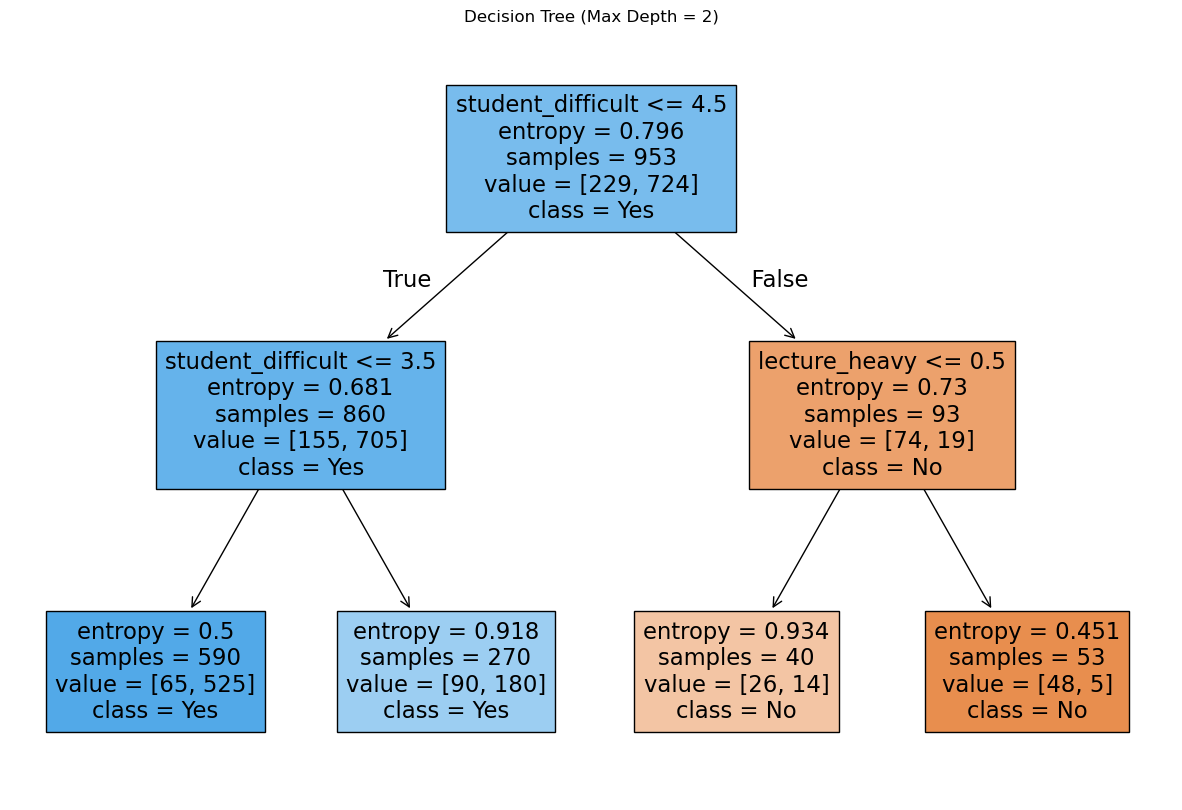


Validation results max_depth=3:
              precision    recall  f1-score   support

           0       0.88      0.36      0.51        80
           1       0.82      0.98      0.89       238

    accuracy                           0.83       318
   macro avg       0.85      0.67      0.70       318
weighted avg       0.84      0.83      0.80       318



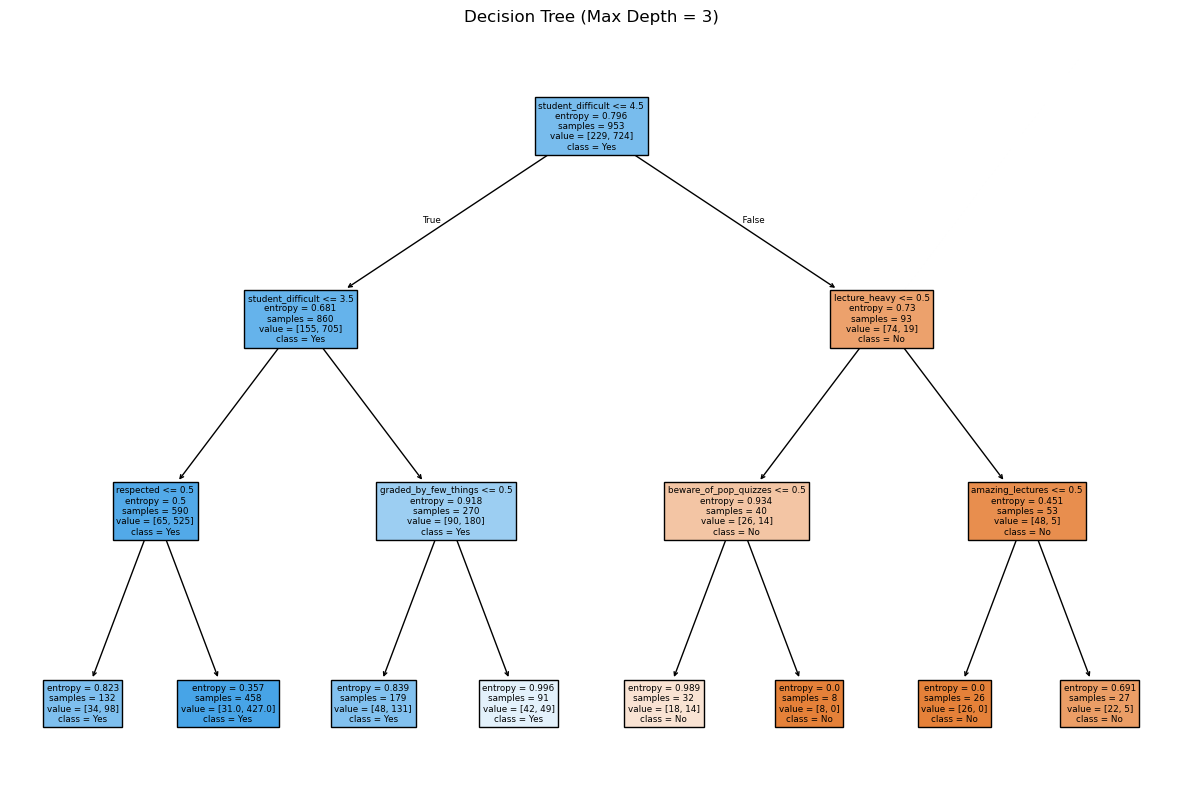


Validation results max_depth=4:
              precision    recall  f1-score   support

           0       0.66      0.51      0.58        80
           1       0.85      0.91      0.88       238

    accuracy                           0.81       318
   macro avg       0.75      0.71      0.73       318
weighted avg       0.80      0.81      0.80       318



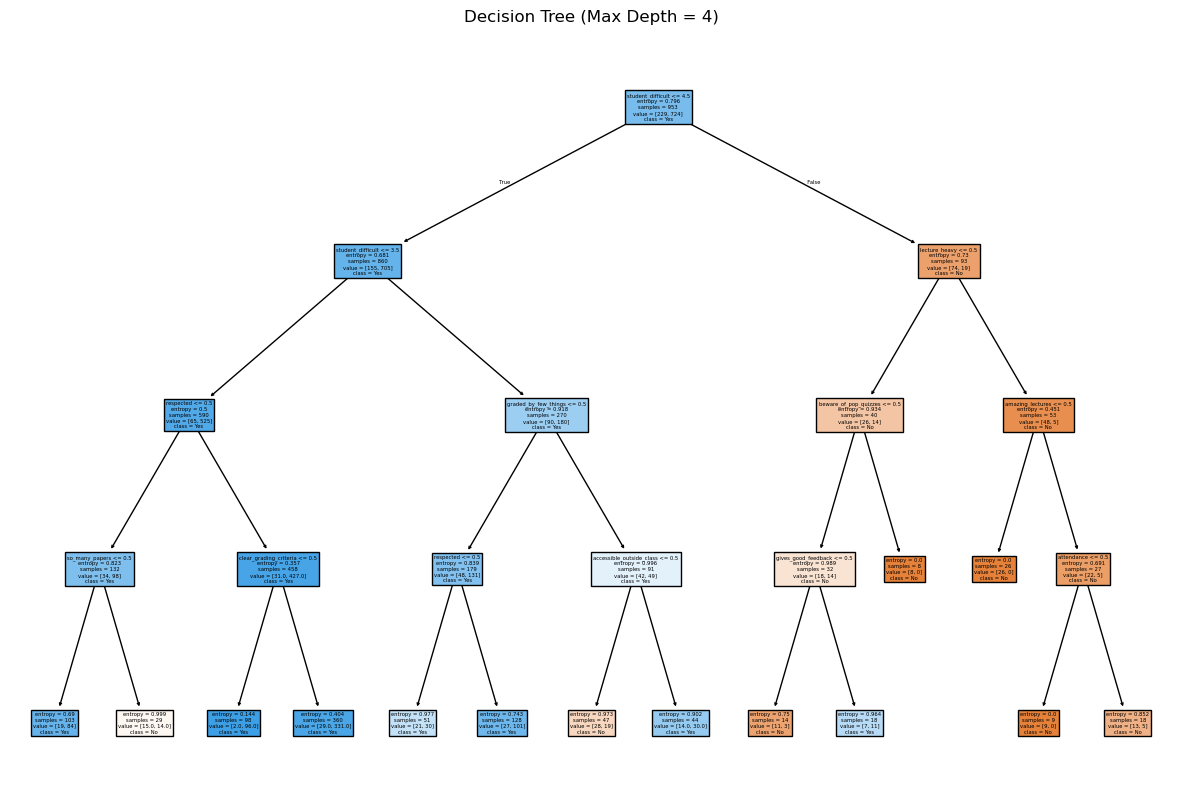

In [30]:
depths = [2, 3, 4]
for depth in depths:
    clf = tree.DecisionTreeClassifier(max_depth=depth, criterion='entropy', random_state=42)
    clf.fit(X_train, y_train)
    y_val_pred = clf.predict(X_val)

    print(f"\nValidation results max_depth={depth}:")
    print(classification_report(y_val, y_val_pred))

    plt.figure()
    plt.gcf().set_size_inches(15, 10)
    tree.plot_tree(clf, feature_names=X.columns, class_names=['No', 'Yes'], filled=True)
    plt.title(f"Decision Tree (Max Depth = {depth})")
    plt.show()


Best tree max_depth = 3:
              precision    recall  f1-score   support

           0       0.75      0.19      0.30        97
           1       0.73      0.97      0.83       221

    accuracy                           0.73       318
   macro avg       0.74      0.58      0.57       318
weighted avg       0.74      0.73      0.67       318

Test Set Accuracy: 0.7327


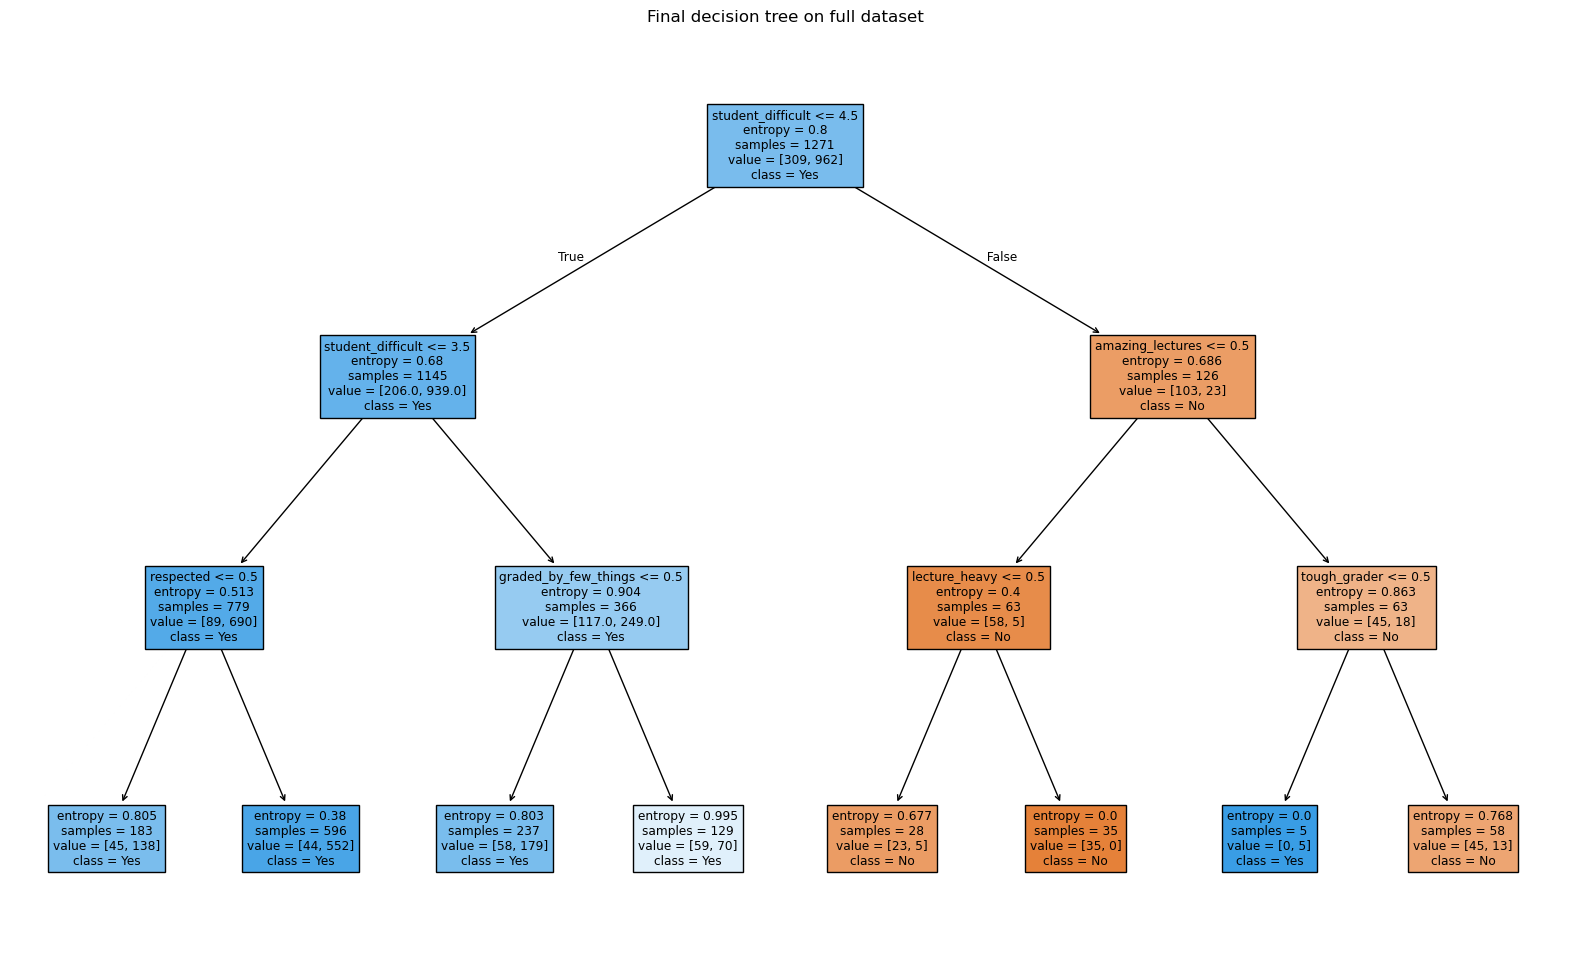

In [31]:
best_depth = 3
clf_best = tree.DecisionTreeClassifier(max_depth=best_depth, criterion='entropy', random_state=42)
clf_best.fit(X_train_val, y_train_val)

y_test_pred = clf_best.predict(X_test)

print("\nBest tree max_depth = 3:")
print(classification_report(y_test, y_test_pred))
print(f"Test Set Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")

plt.figure()
plt.gcf().set_size_inches(20, 12)
tree.plot_tree(clf_best, feature_names=X.columns, class_names=['No', 'Yes'], filled=True)
plt.title("Final decision tree on full dataset")
plt.show()

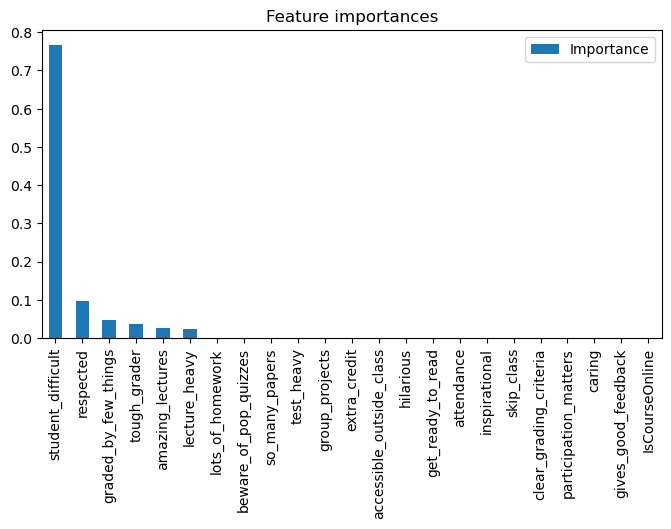

In [32]:
feat_importances = pd.DataFrame(clf_best.feature_importances_, index=X.columns, columns=["Importance"])
feat_importances = feat_importances.sort_values(by='Importance', ascending=False)

feat_importances.plot(kind='bar', figsize=(8,4))
plt.title('Feature importances')
plt.show()

#### part D)

The single decision tree with depth of 3 seems to be a good basic model and has high accuracy. . Based on the feature importance plot, the tree primarily relies on the feature student_difficult, with only little reliance on the features: respected, graded_by_few_things, tough_grader, amazing_lectures, and lecture_heavy. The rest of the features are not important in predicting. This might indicate that the model might be overfitting for one feature and ignoring the influence of the others. The importance values are meaningful since feature importance reflects the total information gain. To improve the model, random forests might create many trees that would reduce overfitting, use more of the secondary features, and limit bias.

#### part E)

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
clf_rf = RandomForestClassifier(max_depth=3, criterion='entropy', random_state=42)
clf_rf.fit(X_train_val, y_train_val)

y_pred_rf = clf_rf.predict(X_test)

rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Test Set Accuracy: {rf_accuracy:.4f}")

tree_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Single Decision Tree Test Set Accuracy: {tree_accuracy:.4f}")

Random Forest Test Set Accuracy: 0.7170
Single Decision Tree Test Set Accuracy: 0.7327


The single decision tree (73.3%) is slightly more accurate than the random forest tree (71.7%). I am surprised by the results because I thought incorporating more importance for the rest of the minor features would improve accuracy, but instead it reduced it.

#### part F)

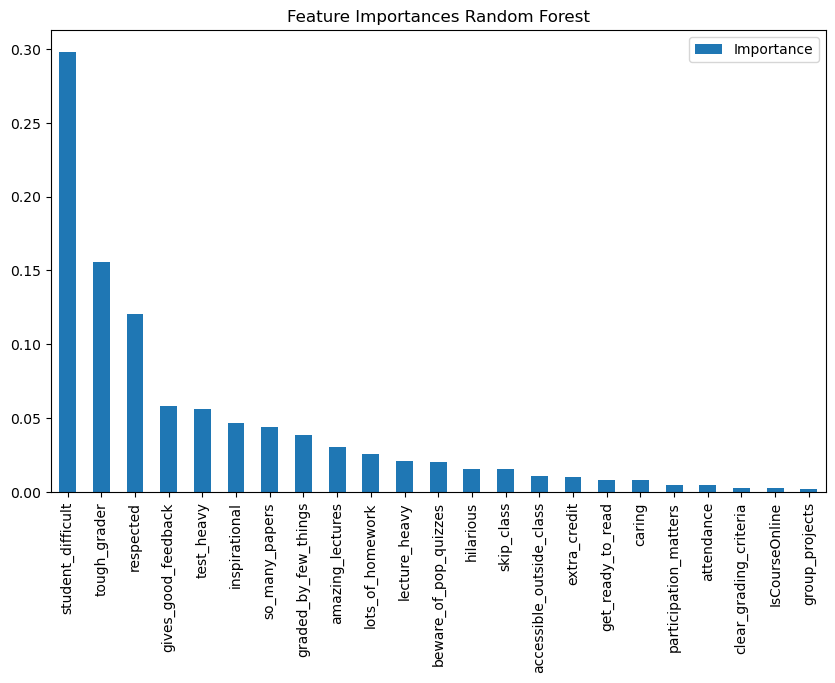

In [35]:
feat_importances_rf = pd.DataFrame(clf_rf.feature_importances_, index=X.columns, columns=["Importance"])
feat_importances_rf = feat_importances_rf.sort_values(by='Importance', ascending=False)

feat_importances_rf.plot(kind='bar', figsize=(10,6))
plt.title('Feature Importances Random Forest')
plt.show()

The feature importances from the random forest model is more evenly distributed compared to the single decision tree. Student_difficult remains the most influential feature in both models. The random forest assigned more importance to additional features such as respected, graded_by_few_things, tough_grader, etc. indicating that the random forest model is less sensitive to overfitting and relies on the whole set of features to make predictions. Overall, additional important features identified by the random forest, such as tough_grader and respected, influence a student’s decision to retake a professor.

### Problem 3
Using the pokemon dataset provided to practice decision trees in a different scenario. 
1. Pre-process pokemon.csv dataset using MinMaxScaler() and split in the train and test sets. The feature to analyze is maintype (fire = 0, water = 1)
2. Train decision trees with depths 2,3,4 to find the best one. 
3. Fit the best depth on the full training dataset and show results.
4. Show feature importance map and analyze the results.
   
#### part A) preprocessing

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
from sklearn.metrics import accuracy_score, classification_report

In [37]:
df = pd.read_csv("pokemon.csv")
df = df.drop(columns=['pokedex', 'pokemon'])

features = ['height', 'weight', 'health', 'basespeed', 'attack', 'defense']
X = df[features].values
y = np.where(df['maintype'] == 'Fire', 0, 1)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [38]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

#### part B) Train decision trees


Decision Tree max depth = 2 results:
              precision    recall  f1-score   support

           0       0.60      1.00      0.75         3
           1       1.00      0.33      0.50         3

    accuracy                           0.67         6
   macro avg       0.80      0.67      0.62         6
weighted avg       0.80      0.67      0.62         6



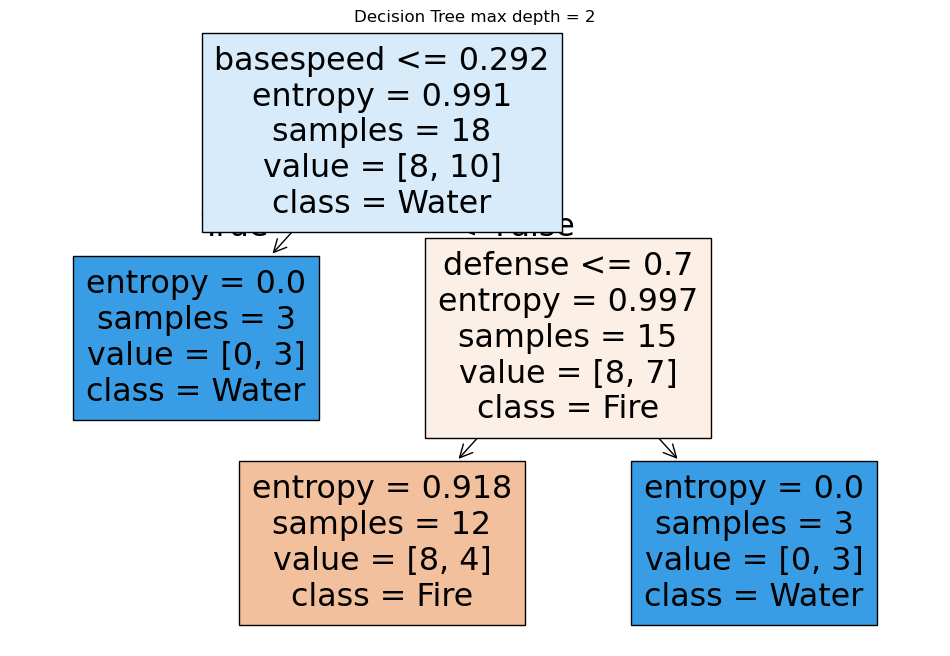


Decision Tree max depth = 3 results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



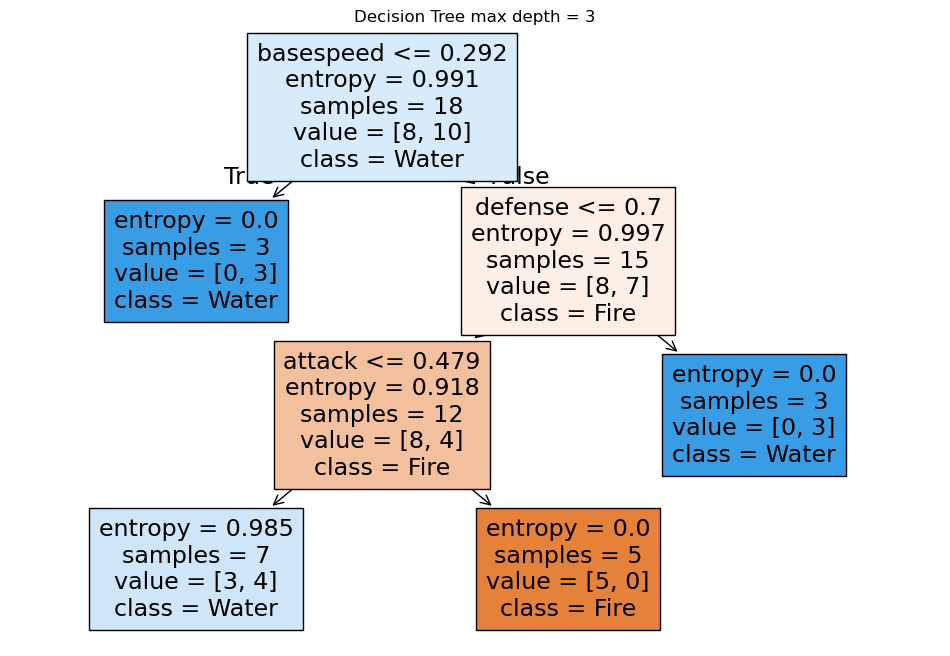


Decision Tree max depth = 4 results:
              precision    recall  f1-score   support

           0       0.60      1.00      0.75         3
           1       1.00      0.33      0.50         3

    accuracy                           0.67         6
   macro avg       0.80      0.67      0.62         6
weighted avg       0.80      0.67      0.62         6



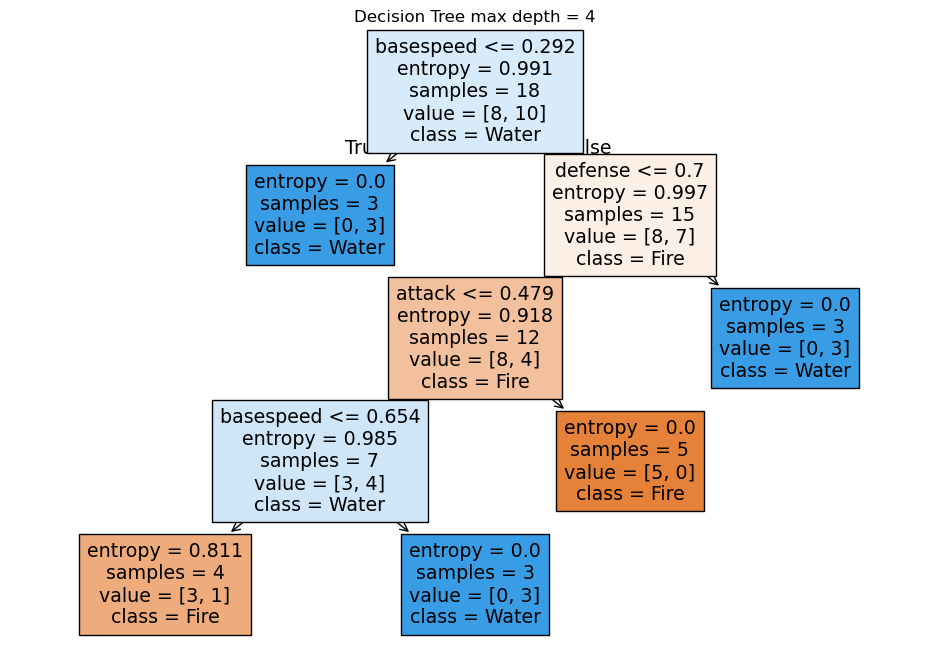

In [39]:
depths = [2, 3, 4]
for depth in depths:
    clf = tree.DecisionTreeClassifier(max_depth=depth, criterion='entropy', random_state=42)
    clf.fit(X_train, y_train)
    y_val_pred = clf.predict(X_val)

    print(f"\nDecision Tree max depth = {depth} results:")
    print(classification_report(y_val, y_val_pred))

    plt.figure()
    plt.gcf().set_size_inches(12, 8)
    tree.plot_tree(clf, feature_names=features, class_names=['Fire', 'Water'], filled=True)
    plt.title(f"Decision Tree max depth = {depth}")
    plt.show()

#### part C) best model results

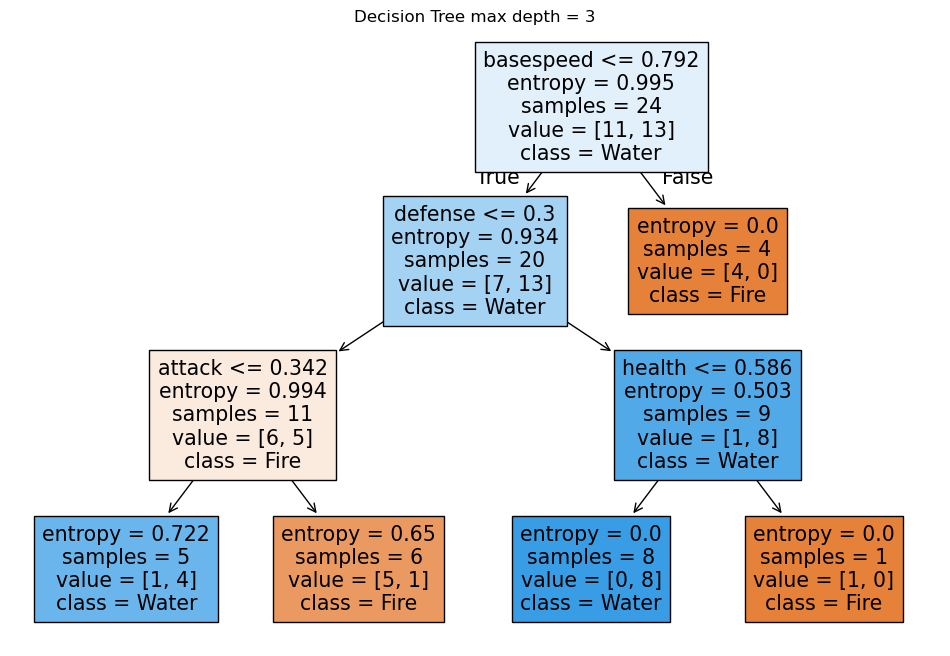

              precision    recall  f1-score   support

           0       0.33      1.00      0.50         1
           1       1.00      0.60      0.75         5

    accuracy                           0.67         6
   macro avg       0.67      0.80      0.62         6
weighted avg       0.89      0.67      0.71         6

accuracy: 0.6667


In [40]:
best_depth = 3
clf_best = tree.DecisionTreeClassifier(max_depth=best_depth, criterion='entropy', random_state=42)
clf_best.fit(X_train_val, y_train_val)

plt.figure()
plt.gcf().set_size_inches(12, 8)
tree.plot_tree(clf_best, feature_names=features, class_names=['Fire', 'Water'], filled=True)
plt.title(f"Decision Tree max depth = {best_depth}")
plt.show()

y_test_pred = clf_best.predict(X_test)

print(classification_report(y_test, y_test_pred))
print(f"accuracy: {accuracy_score(y_test, y_test_pred):.4f}")

#### part D) feature importance and discussion

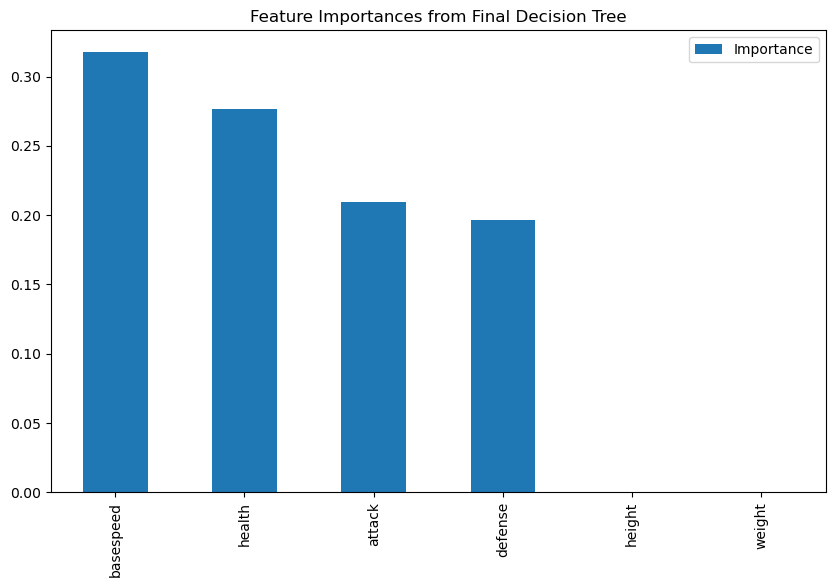

In [41]:
feat_importances = pd.DataFrame(clf_best.feature_importances_, index=features, columns=["Importance"])
feat_importances = feat_importances.sort_values(by='Importance', ascending=False)

feat_importances.plot(kind='bar', figsize=(10,6))
plt.title('Feature Importances from Final Decision Tree')
plt.show()

The decision tree models show strong performance in classifying Pokémon types based on basespeed, health, attack, and defense in respective order of importance based on the feature importance histogram. The tree with depth 3 was selected for the final model, achieving high accuracy on the test set (0.667). The selected features, especially basespeed and health, provide sufficient information to distinguish Fire and Water types of the pokemons in the dataset. Decision trees prove to be an appropriate method for this dataset.